## Virtual Network Embedding Problem Using Hybrid (Quantum-Classical) Approach
### Yasaman Parhizkar
#### University of Tehran - Farvardin 1400

In [1]:
# Load the packages that are required
import numpy as np
import operator
import matplotlib.pyplot as plt

import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')

try:
    import cplex
    from cplex.exceptions import CplexError
except:
    print("Warning: Cplex not found.")
import math

# Qiskit packages
from qiskit import BasicAer
from qiskit.quantum_info import Pauli
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.operators import WeightedPauliOperator

# setup aqua logging
import logging
from qiskit.aqua._logging import set_logging_config, build_logging_config
#set_logging_config(build_logging_config(logging.DEBUG))  # choose INFO, DEBUG to see the log

### Problem Setup

In [2]:
# Setup subtrate and virtual networks
class Initializer():

    def __init__(self, min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap):
        
        self.min_V_size = min_V_size
        self.max_V_size = max_V_size
        self.min_cpu_cap = min_cpu_cap
        self.max_cpu_cap = max_cpu_cap
        self.min_bw_cap = min_bw_cap
        self.max_bw_cap = max_bw_cap
        
    def generate_problem(self):
        
        [n, m] = np.random.randint(low = min_V_size, high = max_V_size + 1, size = 2)
        if n < m:
            (m, n) = (n, m)
        
        SN = self.generate_random_graph(n)
        VN = self.generate_random_graph(m)
        
        return (SN, VN)
        
    def generate_random_graph(self, n):
        
        V = [i for i in range(n)]
        E = [(i, j) for i in V for j in V if i < j and np.random.randint(0,2) == 1]
        E.extend([(j, i) for (i, j) in E])
        T = {i: np.random.randint(min_cpu_cap, max_cpu_cap+1) for i in V}
        D = {(i, j): np.random.randint(min_bw_cap, max_bw_cap+1) for (i, j) in E if i < j}
        D.update({(j, i): D[i, j] for (i, j) in D})
        
        return (V, E, T, D)

    def generate_instance(self, n, D):

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii+1, n):
                if (ii, jj) in D:
                    instance[ii, jj] = D[ii, jj]
                    instance[jj, ii] = D[jj, ii]

        return xc, yc, instance
    
    def visualize_graph(self, xc, yc, instance, B, n, title_str, show_weights = True):
        
        plt.figure()
        plt.scatter(xc, yc, s=200)
        for i in range(len(xc)):
            plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
            
            if show_weights:
                plt.annotate(B[i], (xc[i] + 0.15, yc[i] - 0.45), size=16, color='g')

        plt.grid()

        for ii in range(n):
            for jj in range(ii+1, n):
                if instance[ii][jj]>0:
                    plt.plot([xc[ii], xc[jj]], [yc[ii], yc[jj]], linewidth=2)
                    if show_weights:
                        plt.annotate(int(instance[ii, jj]), (0.5*(xc[ii] + xc[jj]), 0.5*(yc[ii] + yc[jj])), size=16, color='b')

        plt.title(title_str)
        plt.show()

n = 4, m = 3

Subtrate network:
V0 = [0, 1, 2, 3]
E0 = [(0, 1), (1, 2), (1, 3), (2, 3), (1, 0), (2, 1), (3, 1), (3, 2)]
B = {0: 4, 1: 5, 2: 10, 3: 9}
K = {(0, 1): 2, (1, 2): 6, (1, 3): 10, (2, 3): 7, (1, 0): 2, (2, 1): 6, (3, 1): 10, (3, 2): 7}
instance_sn = 
[[ 0.  2.  0.  0.]
 [ 2.  0.  6. 10.]
 [ 0.  6.  0.  7.]
 [ 0. 10.  7.  0.]]

***

Virtual network:
V1 = [0, 1, 2]
E1 = [(0, 2), (2, 0)]
T1 = {0: 9, 1: 6, 2: 3}
D1 = {(0, 2): 9, (2, 0): 9}
instance_vn = 
[[0. 0. 9.]
 [0. 0. 0.]
 [9. 0. 0.]]


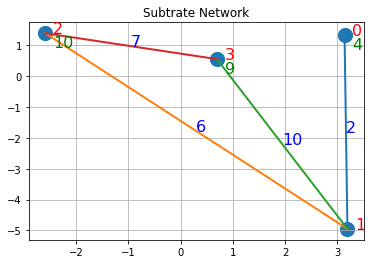

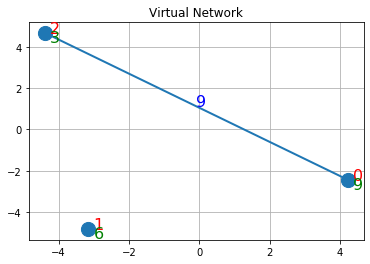

In [3]:
# Initialize the problem by defining the parameters
min_V_size = 3
max_V_size = 4
min_cpu_cap = 1
max_cpu_cap = 10
min_bw_cap = 1
max_bw_cap = 10

np.random.seed(45)

# Construct the graphs of the problem
initializer = Initializer(min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap)
(SN, VN) = initializer.generate_problem()
n = len(SN[0])
m = len(VN[0])
xc_sn, yc_sn, instance_sn = initializer.generate_instance(n, SN[3])
xc_vn, yc_vn, instance_vn = initializer.generate_instance(m, VN[3])

print("n = " + str(n) + ", m = " + str(m) + "\n")

# Show substrate network
print("Subtrate network:")
print("V0 = " + str(SN[0]))
print("E0 = " + str(SN[1]))
print("B = " + str(SN[2]))
print("K = " + str(SN[3]))
print("instance_sn = \n"+str(instance_sn))
print("\n***\n")

# Show virtual network
print("Virtual network:")
print("V1 = " + str(VN[0]))
print("E1 = " + str(VN[1]))
print("T1 = " + str(VN[2]))
print("D1 = " + str(VN[3]))
print("instance_vn = \n"+str(instance_vn))

initializer.visualize_graph(xc_sn, yc_sn, instance_sn, SN[2], n, "Subtrate Network")
initializer.visualize_graph(xc_vn, yc_vn, instance_vn, VN[2], m, "Virtual Network")

* Manual alterations for testing:


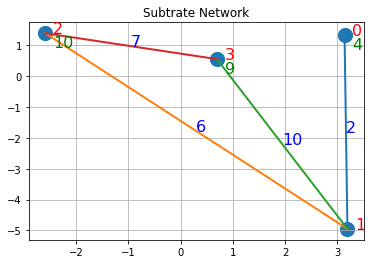

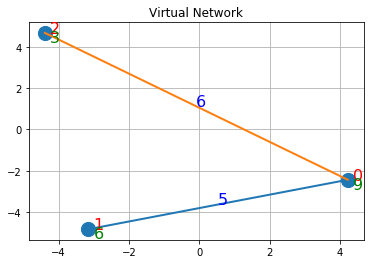

In [4]:
# manual SN and VN alterations for testing
instance_vn[0][2] = 6
instance_vn[2][0] = 6
VN[3][(0,2)] = 6
VN[3][(2,0)] = 6
instance_vn[0][1] = 5
instance_vn[1][0] = 5
VN[1].append((0,1))
VN[1].append((1,0))
VN[3][(0,1)] = 5
VN[3][(1,0)] = 5

print("* Manual alterations for testing:")
initializer.visualize_graph(xc_sn, yc_sn, instance_sn, SN[2], n, "Subtrate Network")
initializer.visualize_graph(xc_vn, yc_vn, instance_vn, VN[2], m, "Virtual Network")

### Node Mapping

In [5]:
class NodeMap:
    
    def __init__(self, SN, VN):
        
        self.V0 = SN[0]
        self.E0 = SN[1]
        self.B = SN[2]
        self.K = SN[3]
        self.V1 = VN[0]
        self.E1 = VN[1]
        self.T1 = VN[2]
        self.D1 = VN[3]
    
    # First policy: max demand node -> max capacity node
    def map_p1(self, show_results = True):
        
        B = self.B
        T1 = self.T1
        V1 = self.V1
        
        sorted_B = sorted(B.items(), key=lambda kv: kv[1], reverse = True)
        sorted_T1 = sorted(T1.items(), key=lambda kv: kv[1], reverse = True)
        node_map = {sorted_T1[i][0]: sorted_B[i][0] for i in range(len(V1))}
        
        if not self.is_feasible(node_map):            
            if show_results:
                print("_NodeMap: infeasible node map (VN->SN = "+str(node_map)+") policy 1.")
            for i in node_map:
                node_map[i] = -1
        elif show_results:
            print("_NodeMap: policy 1 node map: VN->SN = "+str(node_map))
        
        return node_map
    
    # Second policy: each node in sequence -> colsest capacity to the demand of that node
    def map_p2(self, show_results = True):
        
        B = self.B
        T1 = self.T1
        V0 = self.V0
        V1 = self.V1
        
        node_map = {i: 0 for i in range(len(V1))}
        B_k = [i for (i, j) in B.items()]
        B_v = [j for (i, j) in B.items()]
        
        for i in V1:
            j = np.argmin(np.power(B_v - np.ones(len(B_v)) * T1[i], 2))
            node_map[i] = B_k[j]
            B_k.pop(j)
            B_v.pop(j)
            
        if not self.is_feasible(node_map):            
            if show_results:
                print("_NodeMap: infeasible node map (VN->SN = "+str(node_map)+") policy 2.")
            for i in node_map:
                node_map[i] = -1
        elif show_results:
            print("_NodeMap: policy 2 node map: VN->SN = "+str(node_map))
        
        return node_map
    
    # Third policy: summation of differences between node capacities and demands will be minimum
    def map_p3(self, show_results = True):
        
        B = self.B
        T1 = self.T1
        
        # initialization
        node_map = {i: -1 for i in range(len(T1))}
        B_k = [i for (i, j) in B.items()]
        B_v = [j for (i, j) in B.items()]
        T_k = [i for (i, j) in T1.items()]
        T_v = [j for (i, j) in T1.items()]
        inf = (max(B_v) + 1) ** 2

        while T_v != []:

            nn = len(B_v)
            mm = len(T_v)

            # get the distances of each VN node's demand to each SN node's capacity
            distances = np.power(np.kron(np.ones(mm), B_v) - np.kron(T_v, np.ones(nn)), 2)
            distances = distances.reshape(mm, nn)
            decision = np.ones((mm, nn)) * inf
            
            # row-wise minimization
            for ii in range(mm):
                jmin = np.argmin(distances[ii])
                decision[ii][jmin] = distances[ii][jmin]

            # column-wise minimization
            for jj in range(nn):

                temp = [decision[i][jj] for i in range(mm)]
                imin = np.argmin(temp)
                if temp[imin] < inf:
                    node_map[T_k[imin]] = B_k[jj]
            
            # reconstruct B and T based on yet un-mapped nodes
            for ii in node_map:
                if node_map[ii] != -1 and ii in T_k:

                    T_v.pop(T_k.index(ii))
                    T_k.remove(ii)

                    jj = node_map[ii]
                    B_v.pop(B_k.index(jj))
                    B_k.remove(jj)
        
        if not self.is_feasible(node_map):            
            if show_results:
                print("_NodeMap: infeasible node map (VN->SN = "+str(node_map)+") policy 3.")
            for i in node_map:
                node_map[i] = -1
        elif show_results:
            print("_NodeMap: policy 3 node map: VN->SN = "+str(node_map))
                    
        return node_map
    
    def is_feasible(self, node_map):
        
        B = self.B
        T1 = self.T1
        
        for i in node_map:
            if B[node_map[i]] < T1[i]:
                return False
        return True

In [6]:
# Map nodes of virtual network to subtrate network (three policies are available)
node_map = NodeMap(SN, VN)
nm = node_map.map_p1()
print("Map of VN nodes -> SN nodes = " + str(nm))

_NodeMap: policy 1 node map: VN->SN = {0: 2, 1: 3, 2: 1}
Map of VN nodes -> SN nodes = {0: 2, 1: 3, 2: 1}


### Link Mapping
We use quantum optimization for this part.

   * First, we find an optimized path for one link and then repeat the process for every link in VN.
   
### 1- Quantum Routing

In [7]:
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer


class QuantumOptimizer:

    def __init__(self, instance, n, src, des):

        self.instance = instance
        self.n = n
        self.src = src
        self.des = des
        self.z_id = [ii for ii in range(n**2) if instance[ii//n][ii%n]>0]  # index of optimization variables in instance vector
        self.m = len(self.z_id)//2  # number of available edges

    def binary_representation(self,x_sol=0,show_error = True):

        instance = self.instance
        n = self.n
        src = self.src
        des = self.des
        z_id = self.z_id
        m = self.m

        A = np.sum(instance) * 10  # A parameter of cost function

        # Determine the weights w
        instance_vec = instance.reshape(n ** 2)
        w = np.array([instance_vec[x] for x in range(n ** 2) if instance_vec[x] > 0])
#         w_list = [instance_vec[x] for x in range(n ** 2) if instance_vec[x] > 0]
#         w = np.zeros(2*m)
#         for ii in range(len(w_list)):
#             w[ii] = w_list[ii]
        
        # Some variables I will use    
        d = [[1 if x>=ii*n and x<ii*n+n else 0 for x in z_id] for ii in range(n)]
        h = [[1 if x%n==ii else 0 for x in z_id] for ii in range(n)]
        d_sd = [[d[ii][jj] for jj in range(2*m)] for ii in range(n)]
        d_sd[src] = np.zeros(2*m)
        d_sd[des] = np.zeros(2*m)
        
        
        # Q defines the interactions between variables
        Q_p1 = np.dot(np.array(d).T, np.array(d))
        Q_p2 = np.dot(np.array(h).T, np.array(h))
        Q_p3 = np.dot(np.array(d_sd).T, np.array(h))
        Q = A*(Q_p1 + Q_p2 - 2*Q_p3)

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.array(d[src]) + np.array(h[des]))

        # c is the constant offset
        c = 2 * A

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except Exception as exc:
            if show_error:
                print("_QuantumOptimizer: "+str(exc))
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        
        m = self.m
        
        qp = QuadraticProgram()
        for i in range(2*m):
            qp.binary_var(str(i))
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c
        return qp

    def solve_problem(self, qp, show_error = True):
        
        z_id = self.z_id
        n = self.n
        m = self.m
        
        # check that there is at least one optimization variable
        if m==0:
            if show_error:
                print("_QuantumOptimizer: there are no optimization variables.")
            return [], 0
        
        # aqua_globals.random_seed = 10598
        aqua_globals.random_seed = 0
        quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                           seed_simulator=aqua_globals.random_seed,
                                           seed_transpiler=aqua_globals.random_seed)

        vqe = VQE(quantum_instance=quantum_instance)
        optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe)
        result = optimizer.solve(qp)
        
        # compute cost of the obtained result
        _,_,_,level = self.binary_representation(x_sol=result.x)
        
        # put the quantum result in a classical format
        r = result.x
        k = 0
        l = 0
        z_res = np.zeros(n*(n-1))
        for ii in range(n**2):
            if ii in z_id:
                z_res[l] = r[k]
                k = k+1
            if ii//n != ii%n:
                l = l+1
        
        return z_res, level

In [8]:
# define a link that should be found in SN
src_vn, des_vn = VN[1][0]
src_sn, des_sn = (nm[src_vn], nm[des_vn])
print("A path between "+str((src_sn, des_sn))+" should be found in SN")

# Instantiate the quantum optimizer class with parameters
quantum_optimizer = QuantumOptimizer(instance_sn, n, src_sn, des_sn)

# Get binary representation
try:
    Q, g, c, binary_cost = quantum_optimizer.binary_representation()
except NameError as e:
    print("Error when getting the binary representation.")
    print(e)

qp = quantum_optimizer.construct_problem(Q, g, c)

quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp)

print("Path found: "+str(quantum_solution))
print("Path cost = "+str(quantum_cost))

A path between (2, 1) should be found in SN
_QuantumOptimizer: 'int' object is not iterable
Path found: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Path cost = 6.0


### 2- Link Mapping Using Quantum Routing

In [9]:
class LinkMap:
    
    def __init__(self, SN, VN, instance_sn, node_map):
        
        self.V0 = SN[0]
        self.E0 = SN[1]
        self.B = SN[2]
        self.K = SN[3].copy()
        self.V1 = VN[0]
        self.E1 = VN[1]
        self.T1 = VN[2]
        self.D1 = VN[3]
        self.n = len(self.V0)
        self.instance_sn = instance_sn.copy()
        self.node_map = node_map
    
    # Get requested links on substrate network
    def get_links(self):
        
        E1 = self.E1
        node_map = self.node_map
        
        return [(node_map[i], node_map[j]) for (i, j) in E1]
    
    def get_route(self, src, des):
        
        instance_sn = self.instance_sn
        V0 = self.V0
        n = self.n
        
        # Instantiate the quantum optimizer class with parameters:
        quantum_optimizer = QuantumOptimizer(instance_sn, n, src, des)
        
        # Get binary representation
        try:
            Q, g, c, binary_cost = quantum_optimizer.binary_representation(show_error = False)
        except NameError as e:
            print("_LinkMap: error when getting the binary representation:")
            print(e)
        
        qp = quantum_optimizer.construct_problem(Q, g, c)
        
        quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp)

        return quantum_solution, quantum_cost
    
    def update_sn(self, x, demand):
        
        K = self.K
        instance_sn = self.instance_sn
        n = self.n
        
        for ii in range(n*(n-1)):
            if x[ii]>0:
                # find src and des of the edge
                ix = ii//(n-1)
                iy = ii%(n-1)
                if iy >= ix:
                    iy = iy + 1
                
                # update K
                K[(ix, iy)] = K[(ix, iy)] - demand
                K[(iy, ix)] = K[(ix, iy)]
                
                # update instance_sn
                instance_sn[ix][iy] -= demand
                instance_sn[iy][ix] = instance_sn[ix][iy]
                
        self.K = K
        self.instance_sn = instance_sn
        
    
    def map_links(self, show_results = True):
        
        node_map = self.node_map
        D1 = self.D1
        E0 = self.E0
        
        links = self.get_links()
        lm = {(i, j): ([], 0) for (i, j) in links if i < j}
        rev_node_map = {node_map[i]: i for i in node_map}
        
        if len(E0)==0:
            if show_results:
                    print("_LinkMap: there are no edges in SN.")
            return lm
        
        for (i, j) in lm:
            lm[(i, j)] = self.get_route(i, j)
            
            # check feasibility of found route
            demand = D1[(rev_node_map[i], rev_node_map[j])]
            if not self.is_feasible(lm[(i, j)][0], lm[(i, j)][1], demand):
                if show_results:
                    print("_LinkMap: link between "+str((i, j))+" in SN is not feasible.")
                lm[(i, j)] = (lm[(i, j)][0], 0)
            
            else:
                self.update_sn(lm[(i, j)][0], demand)
                if show_results:
                    print("_LinkMap: link between "+str((i, j))+" in SN is found. [demand of "+ \
                          str((rev_node_map[i], rev_node_map[j]))+" in VN = "+str(demand)+"]")
                    print("_LinkMap: SN K has been updated. new SN k =")
                    print("_LinkMap: "+str(self.K))
        
        return lm
    
    def is_feasible(self, x, C, demand):
        
        K = self.K
        n = self.n
        instance_sn = self.instance_sn
        
        A = np.sum(instance_sn) * 10  # A parameter of cost function in quantum optimizer
        
        if C >= A:
            return False
        
        for ii in range(n*(n-1)):
            if x[ii]>0:
                ix = ii//(n-1)
                iy = ii%(n-1)
                if iy >= ix:
                    iy = iy + 1
                
                if K[(ix, iy)] < demand:
                    return False
        return True
        
        
    def display_map(self, lm):
        
        node_map = self.node_map
        
        rev_node_map = {node_map[i]: i for i in node_map}        
        VN_edges = {(i, j): (rev_node_map[i], rev_node_map[j]) for (i, j) in lm}
        
        print("\nLink Map:")
        print("VN edge","SN edge", "cost", "path in SN", sep = '\t\t')
        print("-----------------------------------------------------------------------------")
        for (i, j) in lm:
            print(VN_edges[(i, j)], end = '\t\t')
            print('('+str(i)+", "+str(j)+')', end = '\t\t')
            print(lm[(i, j)][1], end = '\t\t')
            print(lm[(i, j)][0], end = '\n')
            
        print("-----------------------------------------------------------------------------")

In [10]:
# Map edges of virtual network to paths in substrate network

linkmap = LinkMap(SN, VN, instance_sn, nm)

links = linkmap.get_links()
print("Links between these nodes should be found in SN (Equivalents of VN edges):")
print(links)
print(' ')

lm = linkmap.map_links() # Caution: This line takes time to run.
linkmap.display_map(lm)

Links between these nodes should be found in SN (Equivalents of VN edges):
[(2, 1), (1, 2), (2, 3), (3, 2)]
 
_LinkMap: link between (1, 2) in SN is found. [demand of (2, 0) in VN = 6]
_LinkMap: SN K has been updated. new SN k =
_LinkMap: {(0, 1): 2, (1, 2): 0, (1, 3): 10, (2, 3): 7, (1, 0): 2, (2, 1): 0, (3, 1): 10, (3, 2): 7}
_LinkMap: link between (2, 3) in SN is found. [demand of (0, 1) in VN = 5]
_LinkMap: SN K has been updated. new SN k =
_LinkMap: {(0, 1): 2, (1, 2): 0, (1, 3): 10, (2, 3): 2, (1, 0): 2, (2, 1): 0, (3, 1): 10, (3, 2): 2}

Link Map:
VN edge		SN edge		cost		path in SN
-----------------------------------------------------------------------------
(2, 0)		(1, 2)		6.0		[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0, 1)		(2, 3)		7.0		[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
-----------------------------------------------------------------------------


In [11]:
def visualize_route(xc_sn, yc_sn, lm, src, des):

    if (src, des) not in lm:
        print("Error: no link between "+ str((src, des))+" is found in the link map.")
        return

    # Get the requested route
    x = lm[(src, des)][0]
    C = lm[(src, des)][1]
    
    if len(x)==0:
        print("Error: no path is defined between "+ str((src, des))+"in the link map.")
        return

    # Put the solution in a way that is compatible with the classical variables
    x_quantum = np.zeros(n ** 2)
    kk = 0
    for ii in range(n ** 2):
        if ii // n != ii % n:
            x_quantum[ii] = x[kk]
            kk +=  1  

    plt.figure()
    plt.scatter(xc_sn, yc_sn, s=200)

    for i in range(len(xc_sn)):
        plt.annotate(i, (xc_sn[i] + 0.15, yc_sn[i]), size=16, color='r')

    plt.grid()

    for ii in range(0, n ** 2):

        if x_quantum[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc_sn[ix], yc_sn[ix], xc_sn[iy] - xc_sn[ix], yc_sn[iy] - yc_sn[ix], \
                      length_includes_head=True, head_width=.25)

    plt.title('Link '+ str((src, des)) + ', Cost = ' + str(int(C * 100) / 100.))
    plt.show()
    
    if C==0:
        print("Warning: path between "+str((src, des))+" is infeasible.")


* Visualize optimized route for every link:


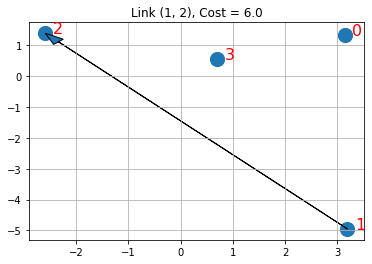

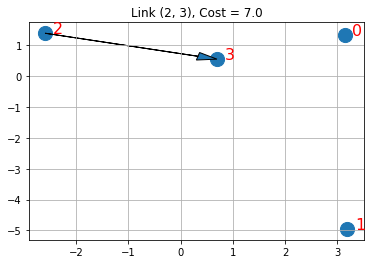

In [12]:
print("\n* Visualize optimized route for every link:")
for (i, j) in links:
    if i < j:
        visualize_route(xc_sn, yc_sn, lm, i, j)

In [13]:
def is_success(nm, lm, VN):

    if nm[0] == -1:
        return False

    if lm == {} and len(VN[1])>0:
        return False

    lm_v = [j for (i, j) in lm.items()]
    lm_c = [j for (i, j) in lm_v]

    if 0 in lm_c:
        return False

    return True

print(is_success(nm, lm, VN))

True


### Gathering it all in one object

In [14]:
class QVNE:
    
    def __init__(self, min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap):
        
        # basic parameters
        self.min_V_size = min_V_size
        self.max_V_size = max_V_size
        self.min_cpu_cap = min_cpu_cap
        self.max_cpu_cap = max_cpu_cap
        self.min_bw_cap = min_bw_cap
        self.max_bw_cap = max_bw_cap
        
        # problem description variables
        self.SN = ()
        self.VN = ()
        self.xc_sn = []
        self.yc_sn = []
        self.xc_vn = []
        self.yc_vn = []
        self.instance_sn = []
        self.instance_vn = []
        self.n = 0
        self.m = 0
        
        # solution variables
        self.nm = {}
        self.lm = {}
        self.links = []
    
    # Setup the problem
    def setup_problem(self, show_results = True):
        
        min_V_size = self.min_V_size
        max_V_size = self.max_V_size
        min_cpu_cap = self.min_cpu_cap
        max_cpu_cap = self.max_cpu_cap
        min_bw_cap = self.min_bw_cap
        max_bw_cap = self.max_bw_cap
        
        # Construct the graphs of the problem
        initializer = Initializer(min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap)
        (SN, VN) = initializer.generate_problem()
        
        n = len(SN[0])
        m = len(VN[0])

        xc_sn, yc_sn, instance_sn = initializer.generate_instance(n, SN[3])
        xc_vn, yc_vn, instance_vn = initializer.generate_instance(m, VN[3])

        if show_results:
            print("_QVNE.setup_problem():")
            initializer.visualize_graph(xc_sn, yc_sn, instance_sn, SN[2], n, "Subtrate Network")
            print("n = " + str(n))
        
            initializer.visualize_graph(xc_vn, yc_vn, instance_vn, VN[2], m, "Virtual Network")
            print("m = " + str(m))
            
        # manual SN and VN alterations for testing
#         instance_sn = np.zeros((n,n))
#         SN = (SN[0], [], SN[2], {})
#         instance_vn = np.zeros((n,n))
#         VN = (VN[0], [], VN[2], {})
#         print("\n_QVNE.setup_problem(): manual test:")
#         print("instance_sn =\n"+str(instance_sn))
#         print("SN[3] = "+str(SN[3]))
#         print("instance_vn =\n"+str(instance_vn))
#         print("VN[3] = "+str(VN[3]))
        
        self.SN = SN
        self.VN = VN
        self.xc_sn = xc_sn
        self.yc_sn = yc_sn
        self.xc_vn = xc_vn
        self.yc_vn = yc_vn
        self.instance_sn = instance_sn
        self.instance_vn = instance_vn
        self.n = n
        self.m = m
    
    # Map nodes of virtual network to subtrate network (three policies are available)   
    def node_map(self, policy = 1, show_results = True):
        
        SN = self.SN
        VN = self.VN
        
        B = SN[2]
        T1 = VN[2]
        nm = {i: -1 for i in VN[0]}
        
        node_map = NodeMap(SN, VN)
        if policy == 1:
            nm = node_map.map_p1(show_results)
        elif policy == 2:
            nm = node_map.map_p2(show_results)
        elif policy == 3:
            nm = node_map.map_p3(show_results)
        elif show_results:
            print("_QVNE.node_map(): policy number should be one of 1, 2, 3 options.")
        
        if nm[0] == -1 and show_results:
            print("_QVNE.node_map(): node mapping was unsuccessful.")
        
        self.nm = nm
        
        if show_results:
            print("_QVNE.node_map(): map of VN->SN nodes = " + str(nm))
        
        return nm
    
    # Map edges of virtual network to paths in substrate network
    def link_map(self, show_results = True):
        
        SN = self.SN
        VN = self.VN
        instance_sn = self.instance_sn
        nm = self.nm
        
        if nm[0]==-1:
            if show_results:
                print("_QVNE.link_map(): node map is not acceptable.")
            return {},[]
           
        linkmap = LinkMap(SN, VN, instance_sn, nm)
        links = linkmap.get_links()
        
        if show_results:
            print("_QVNE.link_map(): links between these nodes should be found in SN (equivalents of VN edges):")
            print("_QVNE.link_map(): "+str(links))
            print(' ')
        
        lm = linkmap.map_links(show_results) # Caution: This line takes time to run.
        
        if show_results:
            linkmap.display_map(lm)
        
        self.lm = lm
        self.links = links
        
        return lm, links
    
    # Visualize the optimized route on SN using its x vector
    def visualize_route(self, src, des):
        
        xc_sn = self.xc_sn
        yc_sn = self.yc_sn
        lm = self.lm
        n = self.n
        
        if (src, des) not in lm:
            print("_QVNE.visualize_route(): no link between "+str((src,des))+" is found in the link map.")
            return
        
        # Get the requested route
        x = lm[(src, des)][0]
        C = lm[(src, des)][1]
        
        if len(x)==0:
            print("_QVNE.visualize_route(): no path is defined between "+str((src, des))+" in the link map.")
            return
        
        # Put the solution in a way that is compatible with the classical variables
        x_quantum = np.zeros(n ** 2)
        kk = 0
        for ii in range(n ** 2):
            if ii // n != ii % n:
                x_quantum[ii] = x[kk]
                kk +=  1  
        
        plt.figure()
        plt.scatter(xc_sn, yc_sn, s=200)
        
        for i in range(len(xc_sn)):
            plt.annotate(i, (xc_sn[i] + 0.15, yc_sn[i]), size=16, color='r')

        plt.grid()

        for ii in range(0, n ** 2):

            if x_quantum[ii] > 0:
                ix = ii // n
                iy = ii % n
                plt.arrow(xc_sn[ix], yc_sn[ix], xc_sn[iy] - xc_sn[ix], yc_sn[iy] - yc_sn[ix], \
                          length_includes_head=True, head_width=.25)

        plt.title('Link '+ str((src, des)) + ', Cost = ' + str(int(C * 100) / 100.))
        plt.show()
        
        if C==0:
            print("_QVNE.visualize_route(): warning: path between "+str((src, des))+" is infeasible.")
    
    # Check if node map and link map are both feasible
    def is_success(self):
        
        nm = self.nm
        lm = self.lm
        VN = self.VN
        
        if nm[0] == -1:
            return False
        
        if lm == {} and len(VN[1])>0:
            return False
        
        lm_v = [j for (i, j) in lm.items()]
        lm_c = [j for (i, j) in lm_v]
        
        if 0 in lm_c:
            return False
        
        return True
    
    def set_links(self, links):
        
        self.links = links
        
    def set_lm(self, lm):
        
        self.lm = lm
        
    def run(self, nm_policy = 1, show_results = True):
        
        if show_results:
            print("_QVNE.run(): seting up the problem.")
        self.setup_problem(show_results)

        if show_results:
            print("\n_QVNE.run(): mapping nodes.")
        nm = self.node_map(policy=nm_policy, show_results=show_results)
        
        if nm[0] == -1:
            if show_results:
                print("_QVNE.run(): node map is infeasible.")
                print("_QVNE.run(): success = False")
            return False

        if show_results:
            print("\n_QVNE.run(): mapping links.")
        lm, links = self.link_map(show_results)
        
        if show_results:
            print("\n_QVNE.run(): visualizing optimized route for every link.")
            if len(lm)==0:
                print("_QVNE.run(): there are no required links in the link map.")
            for (i, j) in lm:
                self.visualize_route(i, j)
            
        success = self.is_success()
        
        if show_results:
            print("_QVNE.run(): success = " + str(success))
            
        return success
    
    def success_ratio(self, nm_policy = 1, shots = 3, show_results = False):
        
        count = 0
        for ii in range(shots):
            
            np.random.seed(ii)
            if self.run(nm_policy=nm_policy, show_results=show_results):
                count = count + 1
                
        return ((count * 1.)/shots)

Below comes three examples of how to use the QVNE object

### Example 1:

* Seting up the problem:
_QVNE.setup_problem():


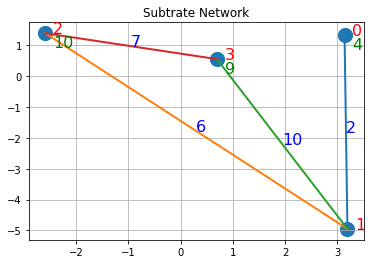

n = 4


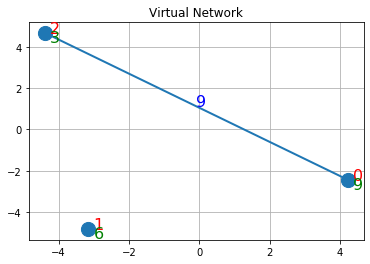

m = 3

* Node mapping:
_NodeMap: policy 1 node map: VN->SN = {0: 2, 1: 3, 2: 1}
_QVNE.node_map(): map of VN->SN nodes = {0: 2, 1: 3, 2: 1}

* Link mapping:
_QVNE.link_map(): links between these nodes should be found in SN (equivalents of VN edges):
_QVNE.link_map(): [(2, 1), (1, 2)]
 
_LinkMap: link between (1, 2) in SN is not feasible.

Link Map:
VN edge		SN edge		cost		path in SN
-----------------------------------------------------------------------------
(2, 0)		(1, 2)		0		[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------------------------------------------------------

* Visualize optimized route for every link:


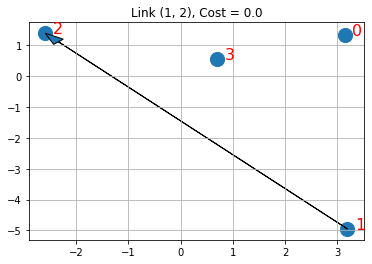

_QVNE.visualize_route(): warning: path between (1, 2) is infeasible.
* Success = False


In [15]:
# 1) Do it all agian using the integrated class of QVNE

# Initialize the problem by defining the parameters
min_V_size = 3
max_V_size = 4
min_cpu_cap = 1
max_cpu_cap = 10
min_bw_cap = 1
max_bw_cap = 10

np.random.seed(45)

qvne = QVNE(min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap)

print("* Seting up the problem:")
qvne.setup_problem()

print("\n* Node mapping:")
nm = qvne.node_map(policy = 1)

print("\n* Link mapping:")
lm, links = qvne.link_map()

print("\n* Visualize optimized route for every link:")
for (i, j) in lm:
    qvne.visualize_route(i, j)

print("* Success = "+str(qvne.is_success()))

### Example 2:

_QVNE.run(): seting up the problem.
_QVNE.setup_problem():


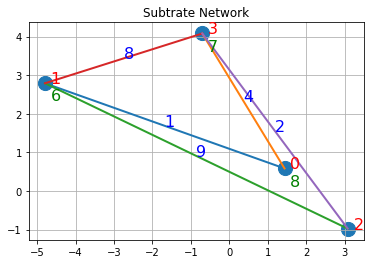

n = 4


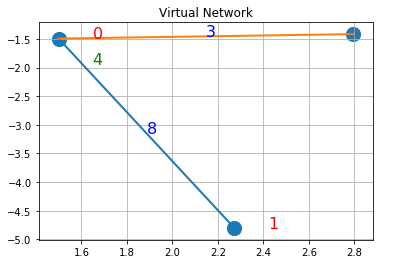

m = 3

_QVNE.run(): mapping nodes.
_NodeMap: policy 3 node map: VN->SN = {0: 1, 1: 0, 2: 2}
_QVNE.node_map(): map of VN->SN nodes = {0: 1, 1: 0, 2: 2}

_QVNE.run(): mapping links.
_QVNE.link_map(): links between these nodes should be found in SN (equivalents of VN edges):
_QVNE.link_map(): [(1, 0), (1, 2), (0, 1), (2, 1)]
 
_LinkMap: link between (1, 2) in SN is found. [demand of (0, 2) in VN = 3]
_LinkMap: SN K has been updated. new SN k =
_LinkMap: {(0, 1): 1, (0, 3): 4, (1, 2): 6, (1, 3): 8, (2, 3): 2, (1, 0): 1, (3, 0): 4, (2, 1): 6, (3, 1): 8, (3, 2): 2}
_LinkMap: link between (0, 1) in SN is not feasible.

Link Map:
VN edge		SN edge		cost		path in SN
-----------------------------------------------------------------------------
(0, 2)		(1, 2)		9.0		[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1, 0)		(0, 1)		0		[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------------------------------------------------------

_QVNE.run(): visualizing optimized route for every link.


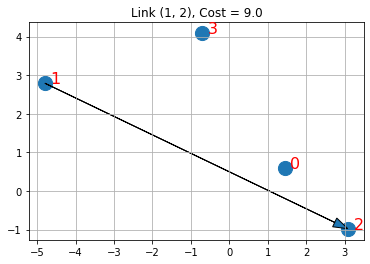

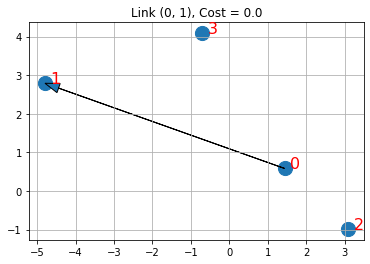

_QVNE.visualize_route(): warning: path between (0, 1) is infeasible.
_QVNE.run(): success = False


False

In [16]:
# 2) Do it all agian using run() method of class QVNE

# Initialize the problem by defining the parameters
min_V_size = 3
max_V_size = 4
min_cpu_cap = 1
max_cpu_cap = 10
min_bw_cap = 1
max_bw_cap = 10

np.random.seed(55)

qvne = QVNE(min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap)
qvne.run(nm_policy = 3, show_results = True)

### Example 3:

In [17]:
# 3) Get success ratio of algorithm by running it multiple times

# Initialize the problem by defining the parameters
min_V_size = 3
max_V_size = 4
min_cpu_cap = 1
max_cpu_cap = 10
min_bw_cap = 1
max_bw_cap = 10

np.random.seed(45)

shots = 3
nm_policy = 1

qvne = QVNE(min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap)
suc_ratio = qvne.success_ratio(nm_policy=nm_policy, shots=shots)

print("Success ratio after " + str(shots) + " runs = " + str(suc_ratio))

Success ratio after 3 runs = 0.0



---

### Note:
Although this algorithm works correctly, it is poorly designed and as you can see, success ratio is almost equal to 0.0.

Better algorithms will be designed in future versions.